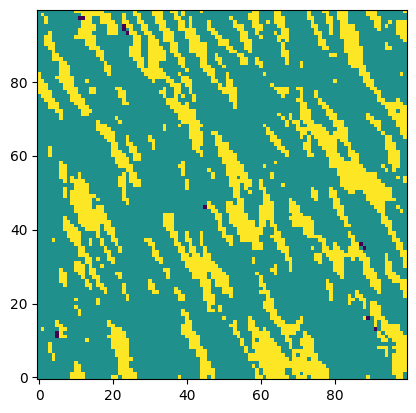

In [4]:
from pathlib import Path
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from fibrosisanalysis.parsers import ImageLoader


path = Path('/home/arstan/Projects/Fibrosis/BiTis/data/original_texs')

image = ImageLoader().load_slice_data(path.joinpath('or_tex_25.png'))

plt.figure()
plt.imshow(image, vmin=0, vmax=2, origin='lower')
plt.show()

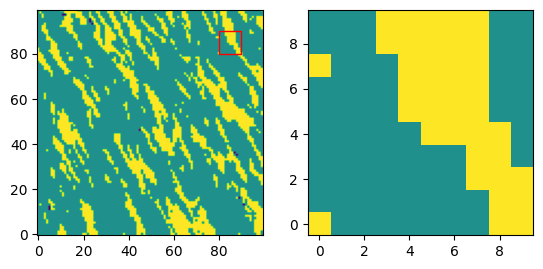

In [5]:
template = image[80:90, 80:90]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image, vmin=0, vmax=2, origin='lower')
axs[0].add_patch(plt.Rectangle((80, 80), 10, 10, edgecolor='r', facecolor='none'))
axs[1].imshow(template, vmin=0, vmax=2, origin='lower')
plt.show()

In [6]:
import numpy as np
from scipy import spatial, signal
from tqdm.notebook import tqdm


class SimulationRandomPathBuilder:
    def __init__(self, out_shape):
        self.out_shape = out_shape

    def build(self):
        X, Y = np.meshgrid(np.arange(self.out_shape[0]),
                           np.arange(self.out_shape[1]))
        coords = np.array([X.ravel(), Y.ravel()]).T
        coords = np.random.permutation(coords)
        return coords


class TemplateBuilder:
    def __init__(self, image, max_size=20, max_distance=30):
        self.image = image
        self.max_size = max_size
        self.max_distance = max_distance

    def build_defaut_template(self, nim, coord, max_distance):
        max_distance *= 2
        i_min = coord[0] - max_distance // 2
        i_min = max(0, i_min)

        i_max = coord[0] + max_distance - max_distance // 2
        i_max = min(nim.shape[0], i_max)

        j_min = coord[1] - max_distance // 2
        j_min = max(0, j_min)

        j_max = coord[1] + max_distance - max_distance // 2
        j_max = min(nim.shape[1], j_max)
        return nim[i_min: i_max, j_min: j_max]

    def build_template(self, ind1, ind2):
        coord = np.array([ind1, ind2])
        coords = np.argwhere(self.image > 0)

        if len(coords) < self.max_size:
            return self.build_defaut_template(self.image, coord,
                                              self.max_distance)
        #  Find the nearest max_size already labeled pixels
        tree = spatial.KDTree(coords)
        d, ind = tree.query(coord, k=self.max_size,
                            distance_upper_bound=self.max_distance)
        ind = ind[d < np.inf]

        if len(ind) < self.max_size:
            return self.build_defaut_template(self.image, coord,
                                              self.max_distance)

        coords = coords[ind]
        i_min, j_min = coords.min(axis=0)
        i_max, j_max = coords.max(axis=0)
        return self.image[i_min:i_max, j_min:j_max]
    
    def update_image(self, x, y, value):
        self.image[x, y] = value


class DistanceBuilder:
    def __init__(self, image, distance_threshold=0.0):
        self.image = image
        self.distance_threshold = distance_threshold

    def calc_distance_map(self, image, template):
        dist_fibr = signal.correlate((image == 2).astype(float),
                                    (template == 2).astype(float),
                                    mode='valid', method='fft')
        dist_myo = signal.correlate((image == 1).astype(float),
                                    (template == 1).astype(float),
                                    mode='valid', method='fft')
        dist = dist_fibr + dist_myo
        return dist / (template > 0).sum()

    def calc_min_distance_idx(self, template):
        if template.sum() == 0:
            x = np.random.randint(self.image.shape[0])
            y = np.random.randint(self.image.shape[1])
            return x, y
        
        distance_map = self.calc_distance_map(self.image, template)
        distance_threshold = max(distance_map.max(), self.distance_threshold)
        coords = np.argwhere(distance_map >= distance_threshold)

        if len(coords) == 0:
            x = np.random.randint(self.image.shape[0])
            y = np.random.randint(self.image.shape[1])
            return x, y

        i = np.random.choice(np.arange(len(coords)))
        x, y = coords[i]
        x += template.shape[0] // 2
        y += template.shape[1] // 2
        return x, y
    
    def build(self, template):
        x, y = self.calc_min_distance_idx(template)
        return self.image[x, y]


class TextureSimulation:
    def __init__(self, image, out_image, max_size=20, max_distance=30,
                 distance_threshold=0.0):
        self.path_builder = SimulationRandomPathBuilder(out_image.shape)
        self.template_builder = TemplateBuilder(out_image, max_size,
                                                max_distance)
        self.distance_builder = DistanceBuilder(image, distance_threshold)
        self.template_sizes = []

    def run(self):
        coords = self.path_builder.build()
        for coord in tqdm(coords):
            template = self.template_builder.build_template(*coord)
            closest_pixel = self.distance_builder.build(template)
            self.template_builder.update_image(*coord, closest_pixel)
            self.template_sizes.append(template.shape)
        return self.template_builder.image

  0%|          | 0/22500 [00:00<?, ?it/s]

0.251 0.2152


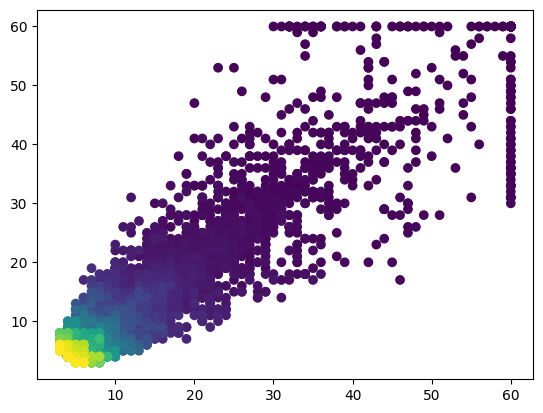

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from fibrosisanalysis.parsers import ImageLoader


# path = Path('/Users/arstanbek/Projects/BiTis/data/training')
# image = ImageLoader().load_slice_data(path.joinpath('or_tex_2.png'))
image = image[:100, :100]
image[image == 0] = 1

image_gen = np.load(path.parent.joinpath('simulated', 'or_tex_2.npy'))
# image_gen = image_gen[:100, :100]

max_neigbours = 20
max_distance = 30

# dens = (image == 2).mean()

# random_map = np.random.random(image.shape)
# precondition = np.zeros_like(image)
# precondition[random_map < 0.02 * dens] = 2
# precondition[random_map > 1 - 0.02 * (1 - dens)] = 1
# precondition[:40, :] = 0
# precondition[:, :40] = 0
# precondition[60:, :] = 0
# precondition[:, 60:] = 0

new_image = np.zeros((150, 150))
texture_simulation = TextureSimulation(image, new_image, 
                                       max_neigbours, max_distance, 0.0)
new_image = texture_simulation.run()

print((image == 2).mean(), (new_image == 2).mean())

template_sizes = np.array(texture_simulation.template_sizes)

plt.figure()
plt.scatter(template_sizes[:, 0], template_sizes[:, 1],
            c=np.arange(len(template_sizes)), cmap='viridis')
plt.show()

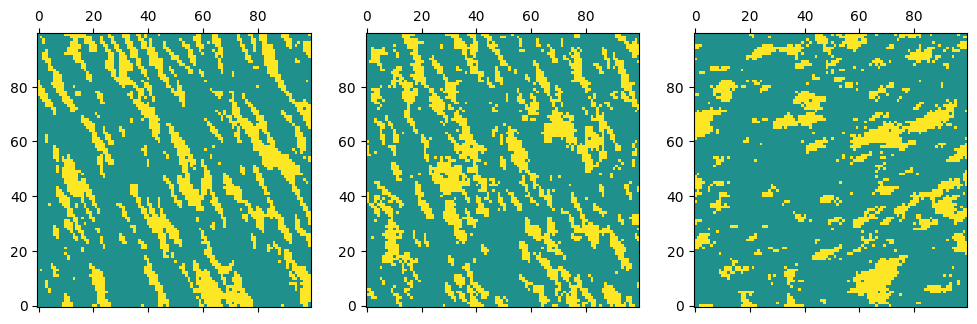

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), width_ratios=[1, 1, 1])
axs[0].matshow(image, vmin=0, vmax=2, origin='lower', aspect='equal')
axs[1].matshow(new_image[25:125, 25:125], vmin=0, vmax=2, origin='lower', aspect='equal')
axs[2].matshow(image_gen[0:100, :100], vmin=0, vmax=2, origin='lower', aspect='equal')
plt.show()

In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.covariance import EmpiricalCovariance
from skimage import measure, morphology, segmentation

from bitis.texture.texture import Texture
from bitis.texture.properties import (
    PatternPropertiesBuilder,
    DistributionEllipseBuilder,
    PolarPlots,
    PointDensity
)


def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])


def swap_axis(angle):
    """
    Swap axis for polar plot.
    """
    return 0.5 * np.pi - angle


def draw_anisotropy(ax, objects_props, n_std=2):
    objects_props = objects_props[objects_props['area'] >= 5]
    r = objects_props['axis_ratio'].values
    theta = objects_props['orientation'].values

    r = np.concatenate([r, r])
    theta = np.concatenate([theta, theta + np.pi])

    theta = swap_axis(theta)

    dist_ellipse_builder = DistributionEllipseBuilder()
    dist_ellipse = dist_ellipse_builder.build(r, theta, n_std=n_std)
    full_theta = dist_ellipse.full_theta
    orientation = dist_ellipse.orientation
    r, theta, d = PolarPlots.sort_by_density(r, theta)

    ax.scatter(theta, r, c=d, s=30, alpha=1, cmap='viridis')
    ax.plot(full_theta, dist_ellipse.full_radius, color='red')

    ax.quiver(0, 0, orientation, 0.5 * dist_ellipse.width,
              angles='xy', scale_units='xy', scale=1, color='red')
    ax.quiver(0, 0, 0.5 * np.pi + orientation,
              0.5 * dist_ellipse.height,
              angles='xy', scale_units='xy', scale=1, color='red')

    # dist_ellipse_builder = DistributionEllipseBuilder()
    # dist_ellipse_builder.cov_estimator = EmpiricalCovariance()
    # dist_ellipse = dist_ellipse_builder.build(r, theta, n_std=n_std)
    # # full_theta = swap_axis(dist_ellipse.full_theta)
    # # orientation = swap_axis(dist_ellipse.orientation)
    # ax.plot(full_theta, dist_ellipse.full_radius, color='blue')


def calc_ccdf(df):
    count = np.bincount(df['area'].values.astype(int))
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


def calc_area_cdf(df):
    count = np.bincount(df['area'].values.astype(int))
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


def draw_area_cdf(ax, objects_props, label=''):
    area_bins, cdf = calc_area_cdf(objects_props)
    ax.plot(area_bins, cdf, label=label)
    ax.set_xlabel('Size')
    ax.set_ylabel('Fibrotic Tissue')
    ax.set_xscale('log')


def draw_ccdf(ax, objects_props, label=''):
    area_bins, ccdf = calc_ccdf(objects_props)
    ax.plot(area_bins, ccdf, label=label)
    ax.set_xlabel('Size')
    ax.set_ylabel('CCDF')
    ax.set_yscale('log')
    ax.set_xscale('log')


def draw_perimeter_cdf(ax, objects_props, label=''):
    count = np.bincount(objects_props['area'].values,
                        weights=objects_props['perimeter'].values)
    area_bins = np.arange(1 + objects_props['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]

    cdf = np.cumsum(count)
    
    ax.plot(area_bins, cdf, label=label)
    ax.set_xlabel('Size')
    ax.set_ylabel('Perimeter')
    ax.set_xscale('log')
    ax.set_yscale('log')



im_gen = new_image[25:125, 25:125]
pattern_props = []
textures = []
for im in [image, im_gen, image_gen]:
    # im = ErosionSegmentation.segment(im == 2)
    pattern_builder = PatternPropertiesBuilder(area_quantile=0.95)
    pattern_properties = pattern_builder.build(im == 2)
    pattern_props.append(pattern_properties)

    texture = Texture()
    texture.matrix = im
    texture.properties["pattern"] = pattern_properties
    texture.properties["object_props"] = pattern_builder.object_props
    textures.append(texture)

print(pd.concat(pattern_props))

fig, axs = plt.subplot_mosaic([['im_or', 'im_gen', 'im_uni'],
                                ['plot', 'plot_gen', 'plot_uni'],
                                ['cmpl', 'cmpl_gen', 'cmpl_uni']],
                                per_subplot_kw={('plot', 'plot_gen',
                                                'plot_uni'): {'projection': 'polar'}})

axs['im_gen'].sharex(axs['im_or'])
axs['im_gen'].sharey(axs['im_or'])

axs['im_uni'].sharex(axs['im_or'])
axs['im_uni'].sharey(axs['im_or'])

axs['plot'].sharex(axs['plot_gen'])
axs['plot'].sharey(axs['plot_gen'])

axs['plot_uni'].sharex(axs['plot_gen'])
axs['plot_uni'].sharey(axs['plot_gen'])

# axs['cmpl'].sharex(axs['cmpl_gen'])
# axs['cmpl'].sharey(axs['cmpl_gen'])
# axs['cmpl_uni'].sharex(axs['cmpl_gen'])
# axs['cmpl_uni'].sharey(axs['cmpl_gen'])

draw_anisotropy(axs['plot'], textures[0].properties["object_props"])
draw_anisotropy(axs['plot_gen'], textures[1].properties["object_props"])
draw_anisotropy(axs['plot_uni'], textures[2].properties["object_props"])

draw_ccdf(axs['cmpl_gen'],
            textures[0].properties["object_props"],
            label='Original')
draw_ccdf(axs['cmpl_gen'],
            textures[1].properties["object_props"],
            label='DS Generator')
draw_ccdf(axs['cmpl_gen'],
            textures[2].properties["object_props"],
            label='Uniform Generator')

draw_area_cdf(axs['cmpl'],
                textures[0].properties["object_props"],
                label='Original')
draw_area_cdf(axs['cmpl'],
                textures[1].properties["object_props"],
                label='DS Generator')
draw_area_cdf(axs['cmpl'],
                textures[2].properties["object_props"],
                label='Uniform Generator')

# draw_perimeter_cdf(axs['cmpl_uni'],
#                    textures[0].properties["object_props"],
#                    label='Original')
# draw_perimeter_cdf(axs['cmpl_uni'],
#                    textures[1].properties["object_props"],
#                    label='DS Generator')
# draw_perimeter_cdf(axs['cmpl_uni'],
#                    textures[2].properties["object_props"],
#                    label='Uniform Generator')

# axs['cmpl_uni'].set_xscale('log')
# axs['cmpl_uni'].set_yscale('log')

axs['cmpl_gen'].legend()

axs['im_or'].imshow(textures[0].matrix, origin='lower')
axs['im_or'].set_title('Original texture')

axs['im_gen'].imshow(textures[1].matrix, origin='lower')
axs['im_gen'].set_title("Generated texture")

axs['im_uni'].imshow(textures[2].matrix, origin='lower')
axs['im_uni'].set_title("Uniform generator")

plt.show()


NameError: name 'pattern_props' is not defined

In [58]:
from tqdm.notebook import tqdm


def reverse(x):
    reverse = (slice(None, None, -1),) * x.ndim
    return x[reverse]


def compute_min_dist_idx(image, template, dist_max=0.0):

    if template.sum() == 0:
        x = np.random.randint(image.shape[0])
        y = np.random.randint(image.shape[1])
        return x, y
    
    dist_fibr = signal.correlate((image == 2).astype(float),
                                 (template == 2).astype(float),
                                 mode='valid', method='fft')
    dist_myo = signal.correlate((image == 1).astype(float),
                                (template == 1).astype(float),
                                mode='valid', method='fft')
    

    # in_image = np.array((image == 2, image == 1), dtype=float)
    # in_template = np.array((reverse(template == 2), reverse(template==1)),
    #                        dtype=float)
    # dist = signal.fftconvolve(in_image, in_template, mode='valid', 
    #                           axes=(1, 2))
    # dist = dist.sum(axis=0)
    dist = dist_fibr + dist_myo
    dist = dist / (template > 0).sum()
    dist_max = max(dist.max(), dist_max)
    coords = np.argwhere(dist >= dist_max)

    if len(coords) == 0:
        x = np.random.randint(image.shape[0])
        y = np.random.randint(image.shape[1])
        return x, y

    i = np.random.choice(np.arange(len(coords)))
    x, y = coords[i]
    x += template.shape[0] // 2
    y += template.shape[1] // 2
    return x, y


def calc_defaut_template(nim, coord, max_distance=50):
    i_min = coord[0] - max_distance // 2
    i_min = max(0, i_min)

    i_max = coord[0] + max_distance - max_distance // 2
    i_max = min(nim.shape[0], i_max)

    j_min = coord[1] - max_distance // 2
    j_min = max(0, j_min)

    j_max = coord[1] + max_distance - max_distance // 2
    j_max = min(nim.shape[1], j_max)
    return nim[i_min: i_max, j_min: j_max]


def calc_template(nim, coord, max_size=100, max_distance=50):
    coords = np.argwhere(nim > 0)

    if len(coords) < max_size:
        return calc_defaut_template(nim, coord, max_distance)

    tree = spatial.KDTree(coords)
    d, ind = tree.query(coord, k=max_size,
                        distance_upper_bound=max_distance)
    ind = ind[d < np.inf]

    if len(ind) < max_size:
        return calc_defaut_template(nim, coord, max_distance)

    coords = coords[ind]
    coords_min = coords.min(axis=0)
    coords_max = coords.max(axis=0)
    i_min = coords_min[0]
    i_max = coords_max[0]
    j_min = coords_min[1]
    j_max = coords_max[1]
    return nim[i_min:i_max, j_min:j_max]


def simulate_image(image, max_neighbours=100, max_distance=50, dist_thr=0.001,
                   precondition=None):
    
    new_image = precondition
    if new_image is None:
        new_image = np.zeros_like(image)

    X, Y = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]))
    coords = np.array([X.ravel(), Y.ravel()]).T
    coords = np.random.permutation(coords)

    template_shapes = []

    for i, j in tqdm(coords[:]):
        if new_image[i, j] != 0:
            continue

        template = calc_template(new_image, (i, j),
                                 max_size=max_neighbours,
                                 max_distance=max_distance)
        
        template_shapes.append([i, j, *template.shape])
        x, y = compute_min_dist_idx(image, template, dist_thr)
        new_image[i, j] = image[x, y]
    return new_image, template_shapes

  0%|          | 0/10000 [00:00<?, ?it/s]

0.5981 0.5928


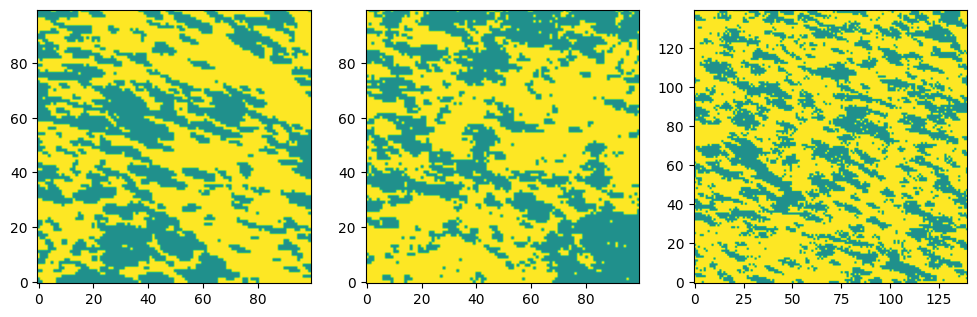

In [59]:
path = 
image = ImageLoader().load_slice_data(path.joinpath('or_tex_200_6.png'))
image_gen = np.load(path.parent.joinpath('sim_dir_2', 'or_tex_200_6.npy'))
image = image[:100, :100]
image[image == 0] = 1
# image = (image == 2).astype(int)
# image[image == 0] = -1

max_neigbours = 20
max_distance = 30

dens = (image == 2).mean()

# random_map = np.random.random(image.shape)
# precondition = np.zeros_like(image)
# precondition[random_map < 0.02 * dens] = 2
# precondition[random_map > 1 - 0.02 * (1 - dens)] = 1
# precondition[:40, :] = 0
# precondition[:, :40] = 0
# precondition[60:, :] = 0
# precondition[:, 60:] = 0
precondition = None

new_image, template_shapes = simulate_image(image, 
                                            max_neigbours, 
                                            max_distance,
                                            dist_thr=0.0,
                                            precondition=precondition)

print((image == 2).mean(), (new_image == 2).mean())

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].imshow(image, vmin=0, vmax=2, origin='lower')
axs[1].imshow(new_image, vmin=0, vmax=2, origin='lower')
axs[2].imshow(image_gen, vmin=0, vmax=2, origin='lower')
plt.show()

In [420]:
template = image[40:50, 40:50]

def reverse(x):
    reverse = (slice(None, None, -1),) * x.ndim
    return x[reverse]


def fftconvolve(image, template):
    in_image = np.array((image == 2, image == 1), dtype=float)
    in_template = np.array((reverse(template == 2), reverse(template==1)),
                        dtype=float)
    dist = signal.fftconvolve(in_image, in_template, mode='valid', 
                                axes=(1, 2))
    return dist.sum(axis=0)


# dist_0 = signal.fftconvolve(in_image[0], reverse(in_template[0]), mode='valid')
# dist_1 = signal.fftconvolve(in_image[1], reverse(in_template[1]), mode='valid')

# print(in_image)

# print(dist.shape)
# dist = dist.sum(axis=0)

def correlate(image, template):
    dist_fibr = signal.correlate((image == 2).astype(float),
                                (template == 2).astype(float),
                                    mode='valid', method='fft')
    dist_myo = signal.correlate((image == 1).astype(float),
                                (template == 1).astype(float),
                                mode='valid', method='fft')
    return dist_fibr + dist_myo


image = ImageLoader().load_slice_data(path.joinpath('or_tex_7.png'))
image[image == 0] = 1

%timeit correlate(image, template)
%timeit fftconvolve(image, template)

# fig, axs = plt.subplots(2, 2, figsize=(8, 8))
# axs = axs.ravel()
# axs[0].imshow(dist[0], origin='lower')
# axs[1].imshow(dist[1], origin='lower')
# axs[2].imshow(dist_fibr, origin='lower')
# axs[3].imshow(dist_myo, origin='lower')
# plt.show()

551 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
552 µs ± 18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


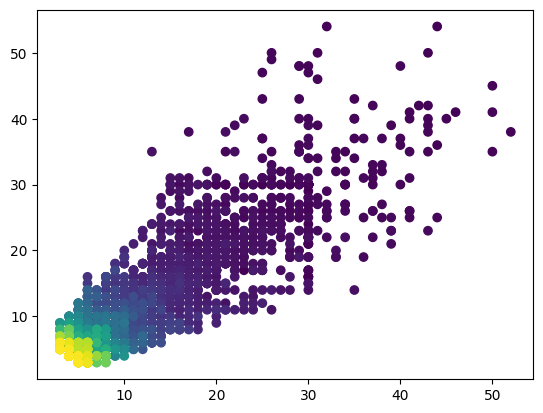

In [346]:
plt.figure()
plt.scatter(np.array(template_shapes)[:, 2], np.array(template_shapes)[:, 3],
            c=np.arange(len(template_shapes)), cmap='viridis')
# plt.yscale('log')
plt.show()

In [109]:
signal.correlate(image, np.zeros((10, 10)), mode='valid', method='fft')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
from scipy import spatial

nim = np.zeros((100, 100))
mask = np.random.random((100, 100)) < 0.01
nim[mask] = 1

print(len(np.argwhere(nim > 0)))
tree = spatial.KDTree(np.argwhere(nim > 0))
d, ind = tree.query([50, 50], k=100, distance_upper_bound=30)
d

84


array([ 5.09901951,  9.05538514, 11.40175425, 12.64911064, 13.15294644,
       13.92838828, 14.86606875, 17.80449381, 18.97366596, 19.02629759,
       19.31320792, 19.41648784, 20.        , 20.1246118 , 20.22374842,
       20.61552813, 21.        , 21.02379604, 23.02172887, 23.34523506,
       23.76972865, 24.8394847 , 25.61249695, 25.70992026, 25.96150997,
       27.01851217, 27.80287755, 29.27456234,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,      

(13, 13)


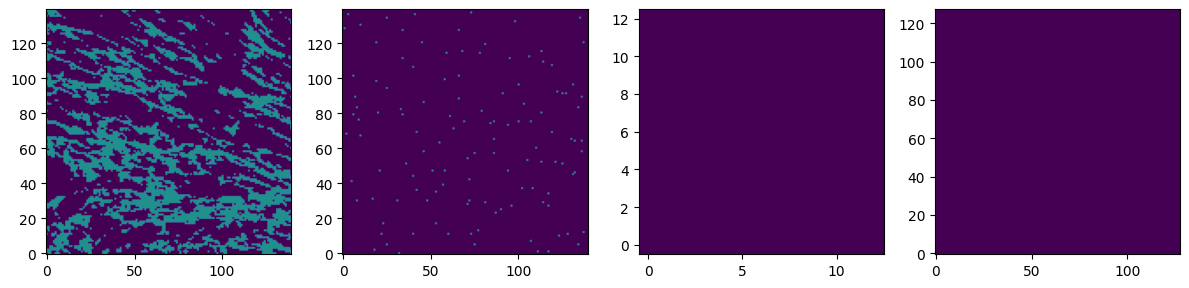

In [47]:
i, j = 10, 10
template_size = 9

image = ImageLoader().load_slice_data(path.joinpath('or_tex_7.png'))
image = (image == 2).astype(int)
new_image = np.zeros_like(image)

i_min = i - template_size // 2
i_max = i + template_size

j_min = j - template_size // 2
j_max = j + template_size

i_min = max(0, i_min)
i_max = min(new_image.shape[0], i_max)

j_min = max(0, j_min)
j_max = min(new_image.shape[1], j_max)

dens = np.mean(image == 1)
mask = np.random.random(image.shape)
new_image[mask < (1 - dens) * 0.01] = 1
# new_image[mask > 1 - 0.01 * dens] = 2

template = new_image[i_min: i_max, j_min: j_max]
print(template.shape)

dist = signal.correlate(image, template, mode='valid', method='fft')

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].imshow(image, vmin=0, vmax=2, origin='lower')
axs[1].imshow(new_image, vmin=0, vmax=2, origin='lower')
axs[2].imshow(template, vmin=0, vmax=2, origin='lower')
axs[3].imshow(dist, origin='lower')
plt.tight_layout()
plt.show()

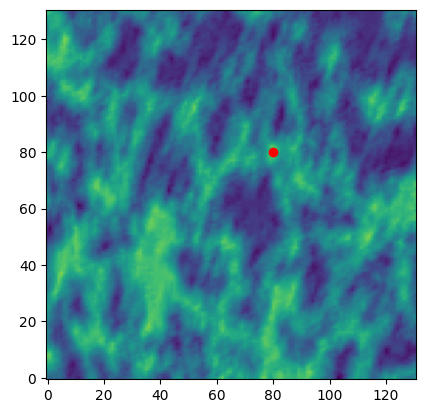

In [46]:
# dist = signal.correlate2d(image, template, mode='valid')

x, y, dist  = compute_min_dist_idx(image, template)

plt.figure()
plt.imshow(dist, origin='lower')
plt.scatter(y, x, color='r')
plt.show()

[[6. 4. 2. 0. 0. 0. 0. 0.]
 [4. 4. 2. 0. 0. 0. 0. 0.]
 [2. 2. 3. 2. 0. 0. 0. 0.]
 [0. 0. 2. 3. 2. 1. 0. 0.]
 [0. 0. 0. 2. 8. 2. 0. 0.]
 [0. 0. 0. 1. 2. 3. 2. 0.]
 [0. 0. 0. 0. 0. 2. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


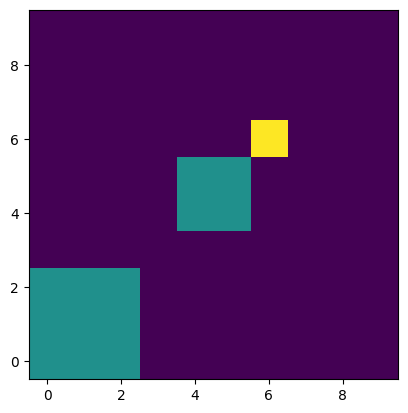

In [43]:
im = np.zeros((10, 10))
im[:3, :3] = 1
im[4:6, 4:6] = 1
im[6:7, 6:7] = 2
tm = im[4:7, 4:7]

dist = signal.correlate2d(im, tm, mode='valid')
print(dist)

plt.figure()
plt.imshow(im, origin='lower')
plt.show()
